# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernible landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [1]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import random

# Define the path to your dataset
data_dir = '/data/landmark_images/'

# Define the path to the original training and test data
original_train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

# Define the data transforms (you can customize these as needed)
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create the original training dataset
original_train_dataset = datasets.ImageFolder(
    root=original_train_dir,
    transform=train_transforms
)

# Define the percentage of data to use for validation
validation_percentage = 20

# Calculate the number of samples for the validation set
num_original_train = len(original_train_dataset)
num_validation = int(validation_percentage / 100 * num_original_train)
num_train = num_original_train - num_validation

# Create a list of indices and shuffle them
indices = list(range(num_original_train))
random.shuffle(indices)

# Split the indices into training and validation sets
train_indices = indices[:num_train]
valid_indices = indices[num_train:]

# Create data loaders for training, validation, and test sets using the indices
batch_size = 32

train_loader = DataLoader(original_train_dataset, batch_size=batch_size, sampler=torch.utils.data.sampler.SubsetRandomSampler(train_indices))
valid_loader = DataLoader(original_train_dataset, batch_size=batch_size, sampler=torch.utils.data.sampler.SubsetRandomSampler(valid_indices))

# Create the test dataset
test_dataset = datasets.ImageFolder(
    root=test_dir,
    transform=test_transforms
)

# Create data loader for the test set
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Store data loaders in the dictionary
loaders_scratch = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: 

The code resizes the images primarily by cropping and, in the case of training data, augmenting them through flips. Here are the details:

Resizing Images: During training, the code employs a "Random Resized Crop" technique. It randomly selects a portion of the original image and resizes it to a fixed size of 224x224 pixels. This involves cropping and resizing.

During testing, the images are first resized to 256x256 pixels while maintaining their aspect ratio. Then, a center crop of 224x224 pixels is taken. This resizing and center cropping ensure that test images have the same size as the training images.

Choice of Input Tensor Size (224x224): The input tensor size of 224x224 pixels was chosen for several reasons:
It is a common standard for training deep convolutional neural networks (CNNs) in computer vision tasks. Many pre-trained models, like VGG and ResNet, are designed for this input size. Consistency in input size simplifies data processing and enables efficient batch processing during both training and testing.

Data Augmentation: Yes, the dataset is augmented during training: Random Horizontal Flip: With a 50% probability, the code applies random horizontal flips to training images. This augmentation technique introduces mirror-image versions of the images. It helps the model learn to recognize objects regardless of their orientation, improving its ability to generalize. 

Reason for Augmentation:Data augmentation is employed to enhance the model's ability to generalize from the limited training data. By introducing variations through flips, the model becomes more robust to different object orientations, which is a valuable feature in real-world scenarios where objects can appear in various orientations.

In summary, the code resizes images using cropping and resizing techniques to achieve a fixed size of 224x224 pixels. During training, data augmentation is applied through random horizontal flips to improve the model's robustness to orientation variations. These preprocessing choices are made to ensure consistent and well-prepared data for training deep neural networks.


### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

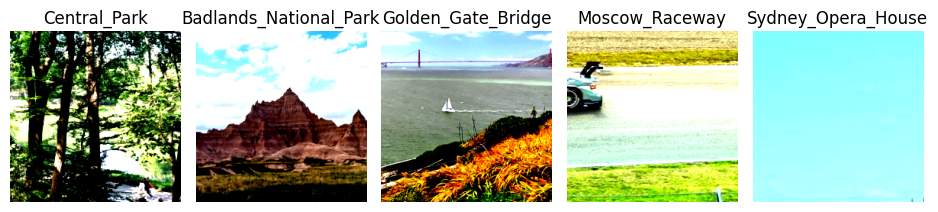

In [2]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## TODO: visualize a batch of the train data loader

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)



# Get a batch of data from the train_loader
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Get class names from the original train_dataset
class_names = original_train_dataset.classes

# Create a function to display images
def imshow(img):
    # Denormalize the image to bring pixel values back to [0, 1]
    img = img / 2 + 0.5
    # Clip pixel values to the valid range [0, 1]
    img = np.clip(img, 0, 1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Plot a selection of images of the batch
plt.figure(figsize=(15, 8))
num_imgs_to_show = 5

for i in range(num_imgs_to_show):
    plt.subplot(4, 8, i + 1)
    imshow(images[i])

    # Skip the first 3 characters
    plt.title(class_names[labels[i]][3:])  
    plt.axis('off')

plt.tight_layout()
plt.show()


### Initialize use_cuda variable

In [3]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()

use_cuda

True

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [4]:
## TODO: select loss function
criterion_scratch = torch.nn.CrossEntropyLoss()

## TODO: select and return an optimizer
def get_optimizer_scratch(model):    
    return torch.optim.Adam(model.parameters(), lr=0.001)
    

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [5]:
import torch.nn as nn

# define the CNN architecture
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        
        ## Define layers of a CNN    
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        
        # Define max-pooling layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # Define fully connected layers
        self.fc1 = nn.Linear(64 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 50)  # 50 classes for classification
        
            
    def forward(self, x):
        ## Define forward behavior
        # Apply convolutional layers
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        
        # Flatten the feature maps
        x = x.view(-1, 64 * 28 * 28)  # Adjust the size based on your architecture
        
        # Apply fully connected layers
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)              
        
        return x

#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  

I started with three convolutional layers (self.conv1, self.conv2, self.conv3) to capture different levels of image features since deeper architectures can capture more complex features.

Kernel sizes of 3x3 were chosen as they are commonly used in CNNs. You can experiment with different kernel sizes.

Padding was set to 1 to maintain the spatial dimensions of the feature maps.

Max-pooling layers (self.pool) were added after each convolutional layer to reduce spatial dimensions and downsample the feature maps.

A kernel size of 2x2 and a stride of 2 were used for max-pooling, which halves the spatial dimensions.

The number of neurons in the output layer (self.fc2) was set to 50 to match the number of classes in my dataset.

The final fully connected layer was preceded by another fully connected layer (self.fc1) with 512 neurons. This intermediate layer allows the network to learn more complex representations.

ReLU (Rectified Linear Unit) activation functions were used after each convolutional layer and the intermediate fully connected layer to introduce non-linearity and improve the network's ability to learn complex patterns.

Before the fully connected layers, the feature maps were flattened to a 1D tensor using x.view().

The final fully connected layer does not have an activation function applied since it's typically followed by a softmax activation in the loss function when using CrossEntropyLoss for classification


### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [6]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
           
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            
            # forward pass
            output = model(data)
            
            # calculate the batch loss
            loss = criterion(output, target)
            
            # backward pass
            loss.backward()
            
            # optimization step
            optimizer.step()
            
            # update the average training loss
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))

        # Print the current training loss    
        # print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))
        
            
        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss 
            # forward pass
            output = model(data)
            
            # calculate the batch loss
            loss = criterion(output, target)
            
            # update the average validation loss
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss < valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model...'.format(
                valid_loss_min,
                valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
        
        
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [7]:
import torch.nn.init as init

def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        # Apply Xavier/Glorot initialization to convolutional and linear layers
        init.xavier_uniform_(m.weight.data)
        if m.bias is not None:
            init.constant_(m.bias.data, 0.0)  # Initialize biases to zero
   
    

#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(20, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

Epoch: 1 	Training Loss: 4.257734 	Validation Loss: 3.767372
Validation loss decreased (inf --> 3.767372). Saving model...
Epoch: 2 	Training Loss: 3.675645 	Validation Loss: 3.600640
Validation loss decreased (3.767372 --> 3.600640). Saving model...
Epoch: 3 	Training Loss: 3.493929 	Validation Loss: 3.564093
Validation loss decreased (3.600640 --> 3.564093). Saving model...
Epoch: 4 	Training Loss: 3.349082 	Validation Loss: 3.397434
Validation loss decreased (3.564093 --> 3.397434). Saving model...
Epoch: 5 	Training Loss: 3.232334 	Validation Loss: 3.344847
Validation loss decreased (3.397434 --> 3.344847). Saving model...
Epoch: 6 	Training Loss: 3.064534 	Validation Loss: 3.186345
Validation loss decreased (3.344847 --> 3.186345). Saving model...
Epoch: 7 	Training Loss: 2.988627 	Validation Loss: 3.107093
Validation loss decreased (3.186345 --> 3.107093). Saving model...
Epoch: 8 	Training Loss: 2.848313 	Validation Loss: 3.075728
Validation loss decreased (3.107093 --> 3.075728

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [8]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 15

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 3.874856 	Validation Loss: 3.742149
Validation loss decreased (inf --> 3.742149). Saving model...
Epoch: 2 	Training Loss: 3.628886 	Validation Loss: 3.568121
Validation loss decreased (3.742149 --> 3.568121). Saving model...
Epoch: 3 	Training Loss: 3.444730 	Validation Loss: 3.549899
Validation loss decreased (3.568121 --> 3.549899). Saving model...
Epoch: 4 	Training Loss: 3.318870 	Validation Loss: 3.309897
Validation loss decreased (3.549899 --> 3.309897). Saving model...
Epoch: 5 	Training Loss: 3.162714 	Validation Loss: 3.327247
Epoch: 6 	Training Loss: 3.027732 	Validation Loss: 3.198867
Validation loss decreased (3.309897 --> 3.198867). Saving model...
Epoch: 7 	Training Loss: 2.913013 	Validation Loss: 3.090903
Validation loss decreased (3.198867 --> 3.090903). Saving model...
Epoch: 8 	Training Loss: 2.800811 	Validation Loss: 2.994041
Validation loss decreased (3.090903 --> 2.994041). Saving model...
Epoch: 9 	Training Loss: 2.669409 	Validation Lo

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [9]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)          
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.399649


Test Accuracy: 38% (450/1155)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [10]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

batch_size = 32

loaders_transfer = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}



### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [11]:
import torch.optim as optim

## TODO: select loss function
criterion_transfer = torch.nn.CrossEntropyLoss()

## TODO: select and return optimizer
def get_optimizer_transfer(model):
    return optim.SGD(model.classifier.parameters(), lr=0.01)   
    

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [12]:
## TODO: Specify model architecture
import torch.nn as nn
from torchvision import models

# Load the pre-trained VGG-16 model
model_transfer = models.vgg16(pretrained=True)

# Freeze the parameters in the feature layers to avoid updating them during training
for param in model_transfer.features.parameters():
    param.requires_grad = False
    
# Get the number of input features of the last layer
num_features = model_transfer.classifier[6].in_features 

# Replace the last layer in the classifier with a new layer
# The new layer should have the same number of input features and 50 output features (number of classes)
model_transfer.classifier[6] = nn.Linear(num_features, 50)  

# Print the modified model architecture
print(model_transfer)

#-#-# Do NOT modify the code below this line. #-#-#
if use_cuda:
    model_transfer = model_transfer.cuda()


c:\Users\Peter.Derkx\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Peter.Derkx\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  

Steps taken:

1. Selection of Pre-trained Model
   The VGG-16 model is selected for its proven capability in image feature extraction, being pre-trained on the comprehensive ImageNet dataset.

2. Freezing Feature Layers
   Freeze all layers in VGG-16's feature extraction section. This prevents their well-trained weights from altering during the training process, aiding in combating overfitting, especially important for smaller datasets.

3. Modifying the Classifier
   Alter the classifier's architecture of the VGG-16. Replace the original final fully connected layer, which outputs 1000 classes, with a new layer designed for 50 classes, aligning with the new task's requirements.

4. Ensuring Compatibility
   The new final layer is configured to have the same number of input features as the original, ensuring it integrates well with the existing network structure.

5. Utilization of CUDA
   If CUDA is available, transfer the model to the GPU. This leverages the GPU's processing power for faster training.

6. Final Architecture Review
   The modified VGG-16 model now offers a blend of pre-learned, robust feature extraction and a tailor-made classification layer, making it suitable for the task of classifying images into 50 classes, particularly when training data is limited.

The modified VGG-16 architecture is suitable for classifying images into 50 categories, thanks to its:
1. Proven Effectiveness: Leveraging the pre-trained VGG-16 model for its robust image recognition capabilities.

2. Overfitting Prevention: Freezing pre-trained layers helps in avoiding overfitting, particularly useful with smaller datasets.

3. Efficient Adaptability and Training: The custom final layer aligns with specific classification needs, ensuring a balance between using robust, pre-learned features and efficient training for rapid model deployment.


### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [13]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'

# Specify the number of epochs
n_epochs = 20

# Specify the save path
save_path = 'model_transfer.pt'

# Train the model
model_transfer = train(n_epochs, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer), criterion_transfer, use_cuda, save_path)


#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 2.528054 	Validation Loss: 1.687078
Validation loss decreased (inf --> 1.687078). Saving model...
Epoch: 2 	Training Loss: 1.562561 	Validation Loss: 1.344043
Validation loss decreased (1.687078 --> 1.344043). Saving model...
Epoch: 3 	Training Loss: 1.331650 	Validation Loss: 1.261968
Validation loss decreased (1.344043 --> 1.261968). Saving model...
Epoch: 4 	Training Loss: 1.216096 	Validation Loss: 1.174346
Validation loss decreased (1.261968 --> 1.174346). Saving model...
Epoch: 5 	Training Loss: 1.091593 	Validation Loss: 1.156627
Validation loss decreased (1.174346 --> 1.156627). Saving model...
Epoch: 6 	Training Loss: 1.035347 	Validation Loss: 1.176110
Epoch: 7 	Training Loss: 0.976504 	Validation Loss: 1.135864
Validation loss decreased (1.156627 --> 1.135864). Saving model...
Epoch: 8 	Training Loss: 0.922675 	Validation Loss: 1.107648
Validation loss decreased (1.135864 --> 1.107648). Saving model...
Epoch: 9 	Training Loss: 0.867002 	Validation Lo

<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [14]:
# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

# load the model that got the best validation accuracy
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.796179


Test Accuracy: 80% (928/1155)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [15]:
import cv2
from PIL import Image

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

# Set the model to evaluation mode
model_transfer.eval()


def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN

    # Load and preprocess the image
    img = Image.open(img_path)
    img_transformed = test_transforms(img)

    # Add batch dimension
    img_transformed = img_transformed.unsqueeze(0)
    
    # Move the image to the same device as the model
    if torch.cuda.is_available():
        img_transformed = img_transformed.cuda()

    # Forward pass, get the top k predictions
    with torch.no_grad():
        outputs = model_transfer(img_transformed)
    
    # Convert outputs to predicted class indices
    _, topk_indices = torch.topk(outputs, k)
    
    # Convert to class names
    # Ensure you have a list or dictionary of class names available
    class_names = [original_train_dataset.classes[idx][3:] for idx in topk_indices[0].cpu().numpy()]
    
    return class_names
   

# test on a sample image
# predict_landmarks('landmark_images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 3)
predict_landmarks('images/test/40.Stockholm_City_Hall/2f02b31d7dfb6e33.jpg', 3)

['Stockholm_City_Hall', 'Niagara_Falls', 'Central_Park']

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

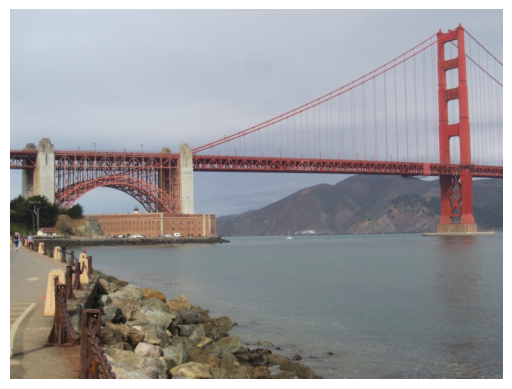

Top 3 suggested locations: 
1. Golden_Gate_Bridge
2. Forth_Bridge
3. Brooklyn_Bridge


In [16]:
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    ## TODO: display image and display landmark predictions

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    # Display the image
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.axis('off')  # Turn off axis labels
    plt.show()

    print('Top 3 suggested locations: ')
    
    # Number and print landmark predictions below the picture
    for i, class_name in enumerate(predicted_landmarks):             
        print(f"{i+1}. {class_name}")

# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

Clearly it cannot classify what is has not been trained on. Three point for improvement:

1. Data Augmentation and Diversification: Enhance the training dataset with more diverse images and apply data augmentation techniques to improve model generalization.
2. Fine-Tuning More Layers: Experiment with fine-tuning additional convolutional layers of the VGG-16 model to better adapt its feature extraction to the specific dataset.
3. Regularization and Ensemble Techniques: Implement regularization methods like dropout and explore ensemble techniques for improved model accuracy and robustness.


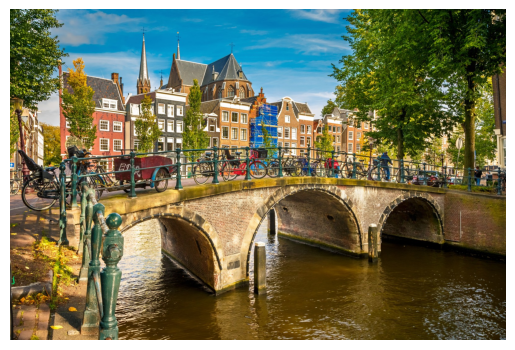

Top 3 suggested locations: 
1. Stockholm_City_Hall
2. Central_Park
3. Taj_Mahal


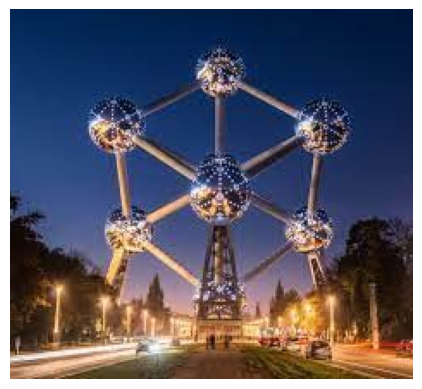

Top 3 suggested locations: 
1. Eiffel_Tower
2. Atomium
3. London_Olympic_Stadium


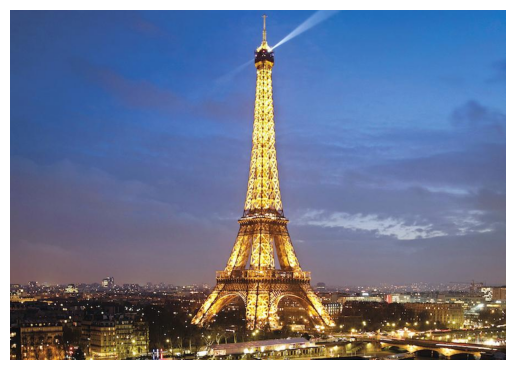

Top 3 suggested locations: 
1. Eiffel_Tower
2. Vienna_City_Hall
3. Terminal_Tower


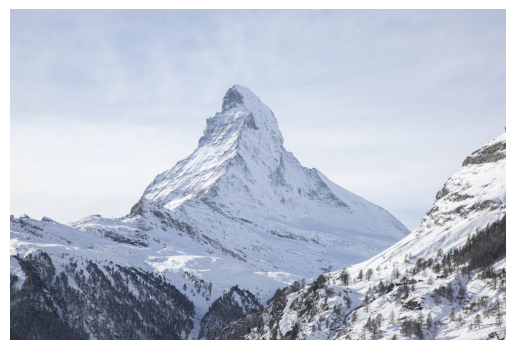

Top 3 suggested locations: 
1. Matterhorn
2. Banff_National_Park
3. Mount_Rainier_National_Park


In [17]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.

# test on a sample image
# suggest_locations('suggest_locations/matterhorn.jpg')

# Directory containing the images
image_directory = 'images'

# List all files in the directory
files_in_directory = os.listdir(image_directory)

# Filter for .jpg files
jpg_files = [file for file in files_in_directory if file.endswith('.jpg')]

# Execute suggest_locations on each .jpg file
for jpg_file in jpg_files:
    file_path = os.path.join(image_directory, jpg_file)
    suggest_locations(file_path)